# Importing Libraries

In [1]:
# normal libraries

from dotenv import load_dotenv
import os
import requests
import json
import pandas as pd
import datetime as dt
from pathlib import Path
import numpy as np

# libraries for analysis

import operator
import collections
from collections import Counter
from sklearn.linear_model import LinearRegression

# libraries for hypothesis

import hvplot.pandas
import plotly.express as px
from bokeh.models.formatters import DatetimeTickFormatter

# libraries for mapbox and dashboard

import panel as pn
import seaborn as sns


Bad key "text.kerning_factor" on line 4 in
C:\Users\dovu9\anaconda3\envs\pyvizenv\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
import matplotlib.pylab as plt


# Importing API keys along with variables and functions

In [3]:
load_dotenv() 

True

In [4]:
# api key to get a radius within a certain zip code, new api key

api_key = os.getenv("ZIPCODE_API_KEY")

# map box api, one we are familiar with

map_box_api = os.getenv("MAPBOX_API_KEY")
px.set_mapbox_access_token(map_box_api)

In [5]:
# testing to see if both API keys pulled in

print(type(api_key))
print(type(map_box_api))

<class 'str'>
<class 'str'>


In [6]:
# Entering in variables for our hypothesis and analysis

center_zip_code = 77002
distance = 10
units = 'miles'
url = f"http://www.zipcodeapi.com/rest/{api_key}/radius.json/{center_zip_code}/{distance}/{units}"

In [7]:
# pulling in data from the zip code api

response_data = requests.get(url)
data = response_data.json()
print(json.dumps(data, indent=4))

{
    "zip_codes": [
        {
            "zip_code": "77048",
            "distance": 9.861,
            "city": "Houston",
            "state": "TX"
        },
        {
            "zip_code": "77045",
            "distance": 9.297,
            "city": "Houston",
            "state": "TX"
        },
        {
            "zip_code": "77246",
            "distance": 8.959,
            "city": "Houston",
            "state": "TX"
        },
        {
            "zip_code": "77247",
            "distance": 8.959,
            "city": "Houston",
            "state": "TX"
        },
        {
            "zip_code": "77061",
            "distance": 9.274,
            "city": "Houston",
            "state": "TX"
        },
        {
            "zip_code": "77035",
            "distance": 9.461,
            "city": "Houston",
            "state": "TX"
        },
        {
            "zip_code": "77051",
            "distance": 7.004,
            "city": "Houston",
            "state": "

In [8]:
# storing the api zip code data into lists

zip_code_list = []
city = []

for line in data["zip_codes"]:

    new_zip_code = int(line["zip_code"])
    zip_code_list.append(new_zip_code)
    
    new_city = line["city"]
    city.append(new_city)

In [10]:
# creating a dataframe to hold the zip code data

zip_code_df = pd.DataFrame()
zip_code_df['zip_code']  = zip_code_list
zip_code_df['City']  = city

In [11]:
# creating a function that'll filter out our datasets for zip codes within our radius

def filter_zip_code(zip_codes_list, df, new_dataframe):
    for zip_code_numbers in zip_codes_list:
        if zip_code_numbers in df:
            data_adding = df.loc[:, zip_code_numbers]
            new_dataframe = new_dataframe.append(data_adding)
    return new_dataframe 

# Data Section

### Importing of the data

In [35]:
# Mapbox data

csvpath_long_lat = Path("../resources/Jack/zip_lat_long.csv")
long_lat_df = pd.read_csv(csvpath_long_lat)

In [13]:
# Tax data 

clean_path = Path("../resources/Vu/Tax_Data/cleaned_tax_FINALs.csv")
clean_tax = pd.read_csv(clean_path)

In [17]:
# Texas Pricing data

csvpath = Path("../resources/Jack/Texas_Pricing_Data.csv")
pricing_data_df = pd.read_csv(csvpath)

In [18]:
# Permit data

permits_filepath = Path("../resources/dan/Permit_Data/permit_data.csv")
permits_df = pd.read_csv(permits_filepath)
permits_df.dropna(inplace=True)

### Cleaning of the data

In [20]:
# tax data

clean_tax = clean_tax.rename({'Zip Code': 'zip_code'}, axis=1)
clean_tax = clean_tax.astype({'zip_code': 'int'})
clean_tax.drop(columns = "Size of adjusted gross income", inplace = True)
multi_index_tax = clean_tax.groupby(["zip_code", "date"]).sum()

In [22]:
# Pricing data

pricing_data_df.set_index(pd.to_datetime(pricing_data_df['month_date_yyyymm'], format='%Y%m', infer_datetime_format=True), inplace=True)
pricing_data_df.index.rename('date', inplace=True)
pricing_data_df.sort_values(by=['postal_code','date'], inplace=True)
pricing_data_df['pct_price_change'] = 0
pricing_data_df['pct_price_sqft_change'] = 0
pricing_data_df['pct_price_sqft_change'] = pricing_data_df['median_listing_price_per_square_feet'].pct_change()
pricing_data_df.index.rename('date', inplace=True)

In [24]:
# Permit data

permits_df = permits_df.astype({'zip_code': 'int64'})
permits_df.set_index(pd.to_datetime(permits_df['date'], format='%Y%m', infer_datetime_format=True), inplace=True)
permits_df.drop('date', axis=1, inplace=True)
permit_counts = permits_df.groupby(["zip_code", "date"]).sum()

### Creating a uniform look for the data

In [36]:
# Mapbox Data

zip_lat_df = pd.pivot_table(long_lat_df, columns = 'Zip', values = 'Latitude')
zip_long_df = pd.pivot_table(long_lat_df, columns = 'Zip', values = 'Longitude')

In [25]:
# tax data

number_of_returns_df = pd.pivot_table(multi_index_tax, index = "date", values = "Number of returns", columns = "zip_code")
taxable_income_df = pd.pivot_table(multi_index_tax, index = "date", values = "Taxable income", columns = "zip_code")
income_tax_df = pd.pivot_table(multi_index_tax, index = "date", values = "Income tax", columns = "zip_code")
mortgage_tax_df = pd.pivot_table(multi_index_tax, index = "date", values = "Mortgage", columns = "zip_code")
charity_tax_df = pd.pivot_table(multi_index_tax, index = "date", values = "Charity", columns = "zip_code")
real_estates_tax_df = pd.pivot_table(multi_index_tax, index = "date", values = "Real Estates", columns = "zip_code")

# Setting index to datetime to match all others

number_of_returns_df.index = pd.to_datetime(number_of_returns_df.index)
number_of_returns_df.sort_index(inplace=True)
taxable_income_df.index = pd.to_datetime(taxable_income_df.index)
taxable_income_df.sort_index(inplace=True)
income_tax_df.index = pd.to_datetime(income_tax_df.index)
income_tax_df.sort_index(inplace=True)
mortgage_tax_df.index = pd.to_datetime(mortgage_tax_df.index)
mortgage_tax_df.sort_index(inplace=True)
charity_tax_df.index = pd.to_datetime(charity_tax_df.index)
charity_tax_df.sort_index(inplace=True)
real_estates_tax_df.index = pd.to_datetime(real_estates_tax_df.index)
real_estates_tax_df.sort_index(inplace=True)

In [23]:
# pricing data

median_list_sqft_df = pd.pivot_table(pricing_data_df, index='date', columns = 'postal_code', values = 'median_listing_price_per_square_feet')
median_list_sqft_df_pct_change = median_list_sqft_df.pct_change()
active_listings_df = pd.pivot_table(pricing_data_df, index='date', columns = 'postal_code', values = 'active_listing_count')
new_listing_df = pd.pivot_table(pricing_data_df, index='date', columns = 'postal_code', values = 'new_listing_count')
average_listing_price_df = pd.pivot_table(pricing_data_df, index='date', columns = 'postal_code', values = 'average_listing_price')
pending_ratio_df = pd.pivot_table(pricing_data_df, index='date', columns = 'postal_code', values = 'pending_ratio')

In [26]:
# permit data

permits_by_zip = pd.pivot_table(permit_counts, index = "date", values = "count", columns = "zip_code")
permits_by_zip = permits_by_zip.groupby(permits_by_zip.index).sum()
permits_by_zip.fillna(0, inplace=True)
permits_by_zip = permits_by_zip.astype(int)

### Running our filter function

In [27]:
# tax data

filtered_median_list_sqft_df = pd.DataFrame()
filtered_median_list_sqft_df = filter_zip_code(zip_code_list, median_list_sqft_df, filtered_median_list_sqft_df)
filtered_median_list_sqft_df.fillna(0, inplace = True)
filtered_median_list_sqft_df = filtered_median_list_sqft_df.transpose()

filtered_median_list_sqft_df_pct_change = pd.DataFrame()
filtered_median_list_sqft_df_pct_change = filter_zip_code(zip_code_list, median_list_sqft_df_pct_change, filtered_median_list_sqft_df_pct_change)
filtered_median_list_sqft_df_pct_change.fillna(0, inplace = True)
filtered_median_list_sqft_df_pct_change = filtered_median_list_sqft_df_pct_change.transpose()

filtered_active_listings_df = pd.DataFrame()
filtered_active_listings_df = filter_zip_code(zip_code_list, active_listings_df, filtered_active_listings_df)
filtered_active_listings_df.fillna(0, inplace = True)
filtered_active_listings_df = filtered_active_listings_df.transpose()

filtered_new_listing_df = pd.DataFrame()
filtered_new_listing_df = filter_zip_code(zip_code_list, new_listing_df, filtered_new_listing_df)
filtered_new_listing_df.fillna(0, inplace = True)
filtered_new_listing_df = filtered_new_listing_df.transpose()

filtered_average_listing_price_df = pd.DataFrame()
filtered_average_listing_price_df = filter_zip_code(zip_code_list, average_listing_price_df, filtered_average_listing_price_df)
filtered_average_listing_price_df.fillna(0, inplace = True)
filtered_average_listing_price_df = filtered_average_listing_price_df.transpose()

filtered_pending_ratio_df = pd.DataFrame()
filtered_pending_ratio_df = filter_zip_code(zip_code_list, pending_ratio_df, filtered_pending_ratio_df)
filtered_pending_ratio_df.fillna(0, inplace = True)
filtered_pending_ratio_df = filtered_pending_ratio_df.transpose()

In [28]:
# Pricing data

filtered_number_of_returns_df = pd.DataFrame()
filtered_number_of_returns_df = filter_zip_code(zip_code_list, number_of_returns_df, filtered_number_of_returns_df)
filtered_number_of_returns_df.fillna(0, inplace = True)
filtered_number_of_returns_df = filtered_number_of_returns_df.transpose()

filtered_taxable_income_df = pd.DataFrame()
filtered_taxable_income_df = filter_zip_code(zip_code_list, taxable_income_df, filtered_taxable_income_df)
filtered_taxable_income_df.fillna(0, inplace = True)
filtered_taxable_income_df = filtered_taxable_income_df.transpose()

filtered_income_tax_df = pd.DataFrame()
filtered_income_tax_df = filter_zip_code(zip_code_list, income_tax_df, filtered_income_tax_df)
filtered_income_tax_df.fillna(0, inplace = True)
filtered_income_tax_df = filtered_income_tax_df.transpose()

filtered_mortgage_tax_df = pd.DataFrame()
filtered_mortgage_tax_df = filter_zip_code(zip_code_list, mortgage_tax_df, filtered_mortgage_tax_df)
filtered_mortgage_tax_df.fillna(0, inplace = True)
filtered_mortgage_tax_df = filtered_mortgage_tax_df.transpose()

filtered_charity_tax_df = pd.DataFrame()
filtered_charity_tax_df = filter_zip_code(zip_code_list, charity_tax_df, filtered_charity_tax_df)
filtered_charity_tax_df.fillna(0, inplace = True)
filtered_charity_tax_df = filtered_charity_tax_df.transpose()

filtered_real_estates_tax_df = pd.DataFrame()
filtered_real_estates_tax_df = filter_zip_code(zip_code_list, real_estates_tax_df, filtered_real_estates_tax_df)
filtered_real_estates_tax_df.fillna(0, inplace = True)
filtered_real_estates_tax_df = filtered_real_estates_tax_df.transpose()


In [29]:
# Permit data

filtered_permits_by_zip = pd.DataFrame()
filtered_permits_by_zip = filter_zip_code(zip_code_list, permits_by_zip, filtered_permits_by_zip)
filtered_permits_by_zip.fillna(0, inplace = True)
filtered_permits_by_zip = filtered_permits_by_zip.transpose()

### Resetting the index and dropping it

In [30]:
# tax data

filtered_real_estates_tax_df.reset_index(inplace = True)
filtered_charity_tax_df.reset_index(inplace = True)
filtered_mortgage_tax_df.reset_index(inplace = True)
filtered_income_tax_df.reset_index(inplace = True)
filtered_taxable_income_df.reset_index(inplace = True)
filtered_number_of_returns_df.reset_index(inplace = True)
filtered_real_estates_tax_df.drop(columns = "index", inplace = True)
filtered_charity_tax_df.drop(columns = "index", inplace = True)
filtered_mortgage_tax_df.drop(columns = "index", inplace = True)
filtered_income_tax_df.drop(columns = "index", inplace = True)
filtered_taxable_income_df.drop(columns = "index", inplace = True)
filtered_number_of_returns_df.drop(columns = "index", inplace = True)

In [31]:
# housing data

filtered_pending_ratio_df.reset_index(inplace = True)
filtered_average_listing_price_df.reset_index(inplace = True)
filtered_new_listing_df.reset_index(inplace = True)
filtered_active_listings_df.reset_index(inplace = True)
filtered_median_list_sqft_df_pct_change.reset_index(inplace = True)
filtered_median_list_sqft_df.reset_index(inplace = True)
filtered_pending_ratio_df.drop(columns = "index", inplace = True)
filtered_average_listing_price_df.drop(columns = "index", inplace = True)
filtered_new_listing_df.drop(columns = "index", inplace = True)
filtered_active_listings_df.drop(columns = "index", inplace = True)
filtered_median_list_sqft_df_pct_change.drop(columns = "index", inplace = True)
filtered_median_list_sqft_df.drop(columns = "index", inplace = True)

In [32]:
# permit data
filtered_permits_by_zip.reset_index(inplace = True)
filtered_permits_by_zip.drop(columns = "index", inplace = True)

# Hypothesis Section

### Scatter Mapbox plot 

In [38]:
median_list_sqft_df_cum_prod = (1+filtered_median_list_sqft_df_pct_change).cumprod()
total_cum_prod_pricing = median_list_sqft_df_cum_prod.iloc[-1].to_frame().transpose()
lat_long_zip_comb_df = pd.concat([zip_lat_df, zip_long_df, total_cum_prod_pricing], join="inner").transpose()
lat_long_zip_comb_df.columns = ('Latitude', 'Longitude', 'Total_Return')
lat_long_zip_comb_df.index.rename('zip', inplace = True)
lat_long_zip_comb_df.reset_index(inplace=True)

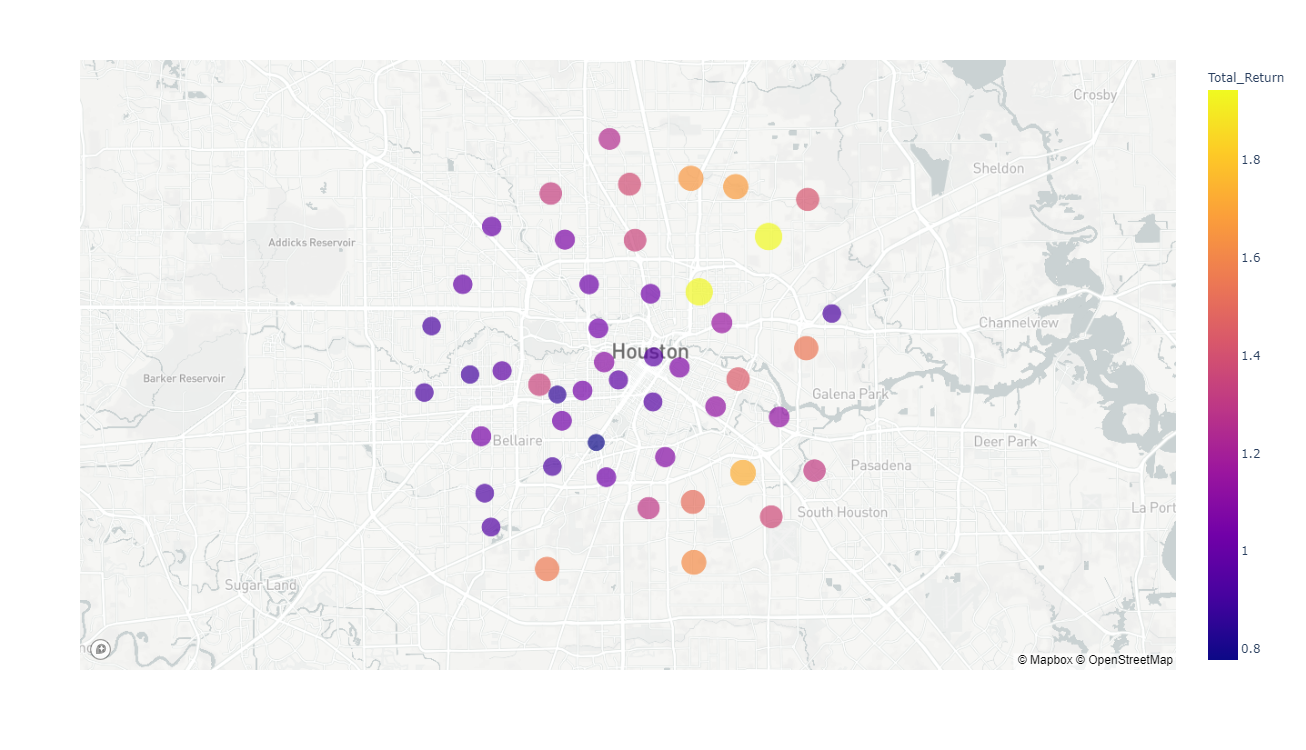

In [77]:
map_total_returns = px.scatter_mapbox(
    lat_long_zip_comb_df,
    lat="Latitude",
    lon="Longitude",
    #text="Zip",
    size="Total_Return",
    color="Total_Return",
    hover_name="zip",
    zoom=10,
    height = 750
)

# Display the map
map_total_returns.show()

### Overall Active Listings

In [42]:
filtered_pricing_data_df = pricing_data_df[pricing_data_df['postal_code'].isin(zip_code_list)]
filtered_pricing_data_df

mean_active_listings_by_date = filtered_pricing_data_df.groupby('date')['active_listing_count'].mean()
mean_active_listings_by_date

# calculate min, max, and std of mean_housing_units_per_year 
min_mean_active_listings = mean_active_listings_by_date.min()
max_mean_active_listings = mean_active_listings_by_date.max()
std_mean_active_listings = mean_active_listings_by_date.std()

# Set ylim min and ylim max values based on min/max/std of housing units above for better scale of housing units
ylim_min = min_mean_active_listings - std_mean_active_listings
ylim_max = max_mean_active_listings + std_mean_active_listings

In [43]:
x_formatter = DatetimeTickFormatter(months='%Y%m')
hyplot_active_listings = mean_active_listings_by_date.hvplot.bar(x='date',y='active_listing_count',rot=90).opts(
    title="Overall Active Listings per Month - Entire Area",
    height=400,
    xlabel='Date',
    ylabel='Active Listing',
    #xticks=25,
    #yformatter="%.0f",
    #xformatter=x_formatter,
    ylim=(ylim_min, ylim_max)
)

### Mean Listing Price

In [44]:
filtered_pricing_data_df = pricing_data_df[pricing_data_df['postal_code'].isin(zip_code_list)]

mean_listing_price_by_date = filtered_pricing_data_df.groupby('date')['median_listing_price'].mean()

# calculate min, max, and std of mean_housing_units_per_year 
min_mean_listing_price_by_date = mean_listing_price_by_date.min()
max_mean_listing_price_by_date = mean_listing_price_by_date.max()
std_mean_listing_price_by_date = mean_listing_price_by_date.std()

# Set ylim min and ylim max values based on min/max/std of housing units above for better scale of housing units
ylim_min = min_mean_listing_price_by_date - std_mean_listing_price_by_date
ylim_max = max_mean_listing_price_by_date + std_mean_listing_price_by_date

In [45]:
x_formatter = DatetimeTickFormatter(months='%Y%m')

hyplot_mean_listing_price = mean_listing_price_by_date.hvplot.bar(x='date',y='median_listing_price',rot=90).opts(
    title="Average Listing Price per Month - Entire Area",
    height=400,
    xlabel='Date',
    ylabel='Average Listing Price',
    #xticks=25,
    yformatter="%.0f",
    #xformatter=x_formatter,
    ylim=(ylim_min, ylim_max)
)


### Median Listing Price per Sqft by Zip Code

In [47]:
plot_df = filtered_pricing_data_df.groupby(['date','postal_code']).mean().reset_index()
plot_df.head()

interactive = plot_df.hvplot.line(x='date',y='median_listing_price_per_square_feet', groupby=['postal_code']).opts(
    title='Median Prices/SqFt per Zip Over Time',
    height=400,
    xlabel='Date',
    ylabel='Median Price/SqFt'
)

### Top Changes in Perecent in Income Tax by Zip Code

In [49]:
income_tax_pctchg = filtered_income_tax_df.pct_change()
income_tax_pctchg.dropna(inplace=True)

income_tax_pctchg_cumprod = (1 + income_tax_pctchg).cumprod() - 1

top10_income_tax_pctchg_cumprod = income_tax_pctchg_cumprod.sum().sort_values(ascending=True)
top10_income_tax_pctchg_cumprod = top10_income_tax_pctchg_cumprod[-10:]


plot_top10_income_tax_pctchg_cumprod = (top10_income_tax_pctchg_cumprod).hvplot.bar(rot=90).opts(
    title="Top 10 Zips by Cumulative Percent Increase in Average Income Tax 2011 - 2015",
    height=400,
    xlabel='Zip Code',
    ylabel='Avg Income Tax Percentage Increase',
    yformatter="%.2f",
    shared_axes = False
    #ylim=(-1, 1)
)

### Top Changes in Percent by Listing Price by Zip Code

In [51]:
avg_list_price_pctchg = filtered_average_listing_price_df.pct_change()
avg_list_price_pctchg.transpose().dropna(inplace = True)
avg_list_price_pctchg_cumprod = (1 + avg_list_price_pctchg).cumprod() - 1
avg_list_price_pctchg_cumprod.fillna(0, inplace=True)
avg_list_price_pctchg_cumprod.replace([np.inf, -np.inf], 0, inplace=True)


top10_avg_list_price_pctchg_cumprod = avg_list_price_pctchg_cumprod.sum().sort_values(ascending=True)
top10_avg_list_price_pctchg_cumprod = top10_avg_list_price_pctchg_cumprod[-10:]



plot_top10_avg_list_price_pctchg_cumprod = (top10_avg_list_price_pctchg_cumprod * 100).hvplot.bar(rot=90).opts(
    title="Top 10 Zips by Cumulative Percent Change in Average Listing Price 2016 - 2020",
    height=400,
    xlabel='Zip Code',
    ylabel='Avg Listing Price Percentage Change',
    yformatter="%.2f",
    shared_axes = False
    #ylim=(-1, 1)
)

### Sum of Permits by Zip Code

In [52]:
top10_sum_permits = filtered_permits_by_zip.sum().sort_values(ascending=True)
top10_sum_permits = top10_sum_permits[-10:]
plot_top10_sum_permits = (top10_sum_permits).hvplot.bar(rot=90).opts(
    title="Top 10 Zips by Construction Permits 2017 - 2020",
    height=400,
    xlabel='Zip Code',
    ylabel='Number Construction Permits',
    yformatter="%.0f",
    shared_axes = False
    #ylim=(-1, 1)
)

### Top Cumulative Percent Increase in Price/Sqft by Zip Code

In [53]:
filtered_price_sqft_pctchg_cumprod = (1 + filtered_median_list_sqft_df_pct_change).cumprod() - 1

top10_cum_increase_price_sqft = filtered_price_sqft_pctchg_cumprod.iloc[-1].sort_values(ascending=True)
top10_cum_increase_price_sqft = top10_cum_increase_price_sqft[-10:]

plot_top10_cum_increase_price_sqft = (top10_cum_increase_price_sqft * 100).hvplot.bar(rot=90).opts(
    title="Top 10 Zip by Cumulative Percent Increase in Price/SqFt 2016 - 2020",
    height=400,
    xlabel='Zip Code',
    ylabel='Percent Increase in Price/SqFt',
    yformatter="%.2f",
    shared_axes = False
)

### Creating Our Dashboard

In [54]:
summary = pn.Column(
    "# We wanted to analyze zip codes within a certain radius, and see which zip code would generate the greatest returns.",
    "# From the availabe data we assumed the top four indicators would be the following:",
    "## Income Tax: With a zipcode of higher income tax, we assume rich would like to live a rich neightborhood.",
    "## Listing Price: Higher listing price should generate more revenue if you can make improvements and sell at a higher value.",
    "## Number of Permits: More permits = more construction = more value in the area",
    "## Percent Increase in Price/Sqft: Higher price = more rent money.",
    width = 800
)

map_column = pn.Column(
        map_total_returns
)

static_plots = pn.Column(
    hyplot_active_listings,
    hyplot_mean_listing_price
)

interactive_plots = pn.Column(
    interactive
)

top_10_zip_codes = pn.Column(
    plot_top10_avg_list_price_pctchg_cumprod,
    plot_top10_income_tax_pctchg_cumprod,
    plot_top10_sum_permits,
    plot_top10_cum_increase_price_sqft
)

conclusion = pn.Column(
    "# In conclusion, we expect zip codes 77003, 77019 and 77007 to be the higest ROI's based off of the critierias that we had identified.",
    width = 800
)

tabs = pn.Tabs(
    ("Summary", summary),
#     ("Heat Index by Zipcode", map_total_returns),
    ("Active Listings & Average Listing Price", static_plots),
    ("Listing Price by Zip Code", interactive_plots),
    ("Top 10 Zip Codes by Criteria", top_10_zip_codes),
    ("Conclusion", conclusion),
    height = 600
)

In [55]:
tabs

Tabs(height=600)
    [0] Column(width=800)
        [0] Markdown(str)
        [1] Markdown(str)
        [2] Markdown(str)
        [3] Markdown(str)
        [4] Markdown(str)
        [5] Markdown(str)
    [1] Column
        [0] HoloViews(Bars)
        [1] HoloViews(Bars)
    [2] Column
        [0] Row
            [0] HoloViews(DynamicMap)
            [1] Column
                [0] WidgetBox
                    [0] DiscreteSlider(margin=(20, 20, 20, 20), name='postal_code', options=OrderedDict([('77002', ...]), value=77002, width=250)
                [1] VSpacer()
    [3] Column
        [0] HoloViews(Bars)
        [1] HoloViews(Bars)
        [2] HoloViews(Bars)
        [3] HoloViews(Bars)
    [4] Column(width=800)
        [0] Markdown(str)

# Analysis Section

### Generating data from historical data for our analysis for future return on investments

In [60]:
# Correlation Calculation

dict_of_corr = {}

for number in zip_code_list:
    if number in filtered_median_list_sqft_df and number in filtered_median_list_sqft_df_pct_change and number in filtered_active_listings_df and number in filtered_new_listing_df and number in filtered_average_listing_price_df and number in filtered_pending_ratio_df and number in filtered_permits_by_zip and number in filtered_number_of_returns_df and number in filtered_taxable_income_df and number in filtered_income_tax_df and number in filtered_mortgage_tax_df and number in filtered_charity_tax_df and number in filtered_real_estates_tax_df:
        dict_of_corr[number] = pd.DataFrame({
            'Median Listing of Sqft Pct Change' : filtered_median_list_sqft_df_pct_change[number], 
            'Active Listings' : filtered_active_listings_df[number], 
            'New Listings' : filtered_new_listing_df[number], 
            'Average Listing Price' : filtered_average_listing_price_df[number],
            'Pending Ratio' : filtered_pending_ratio_df[number],
            'Number of Permits' : filtered_permits_by_zip[number],
            'Number of Tax Returns' : filtered_number_of_returns_df[number],
            'Average Taxable Income' : filtered_taxable_income_df[number],
            'Average Income Tax' : filtered_income_tax_df[number],
            'Average Mortgage Tax' : filtered_mortgage_tax_df[number],
            'Average Charity Tax' : filtered_charity_tax_df[number],
            'Average Real Estates Tax' : filtered_real_estates_tax_df[number]
            }).corr()
        np.fill_diagonal(dict_of_corr[number].values, -2)

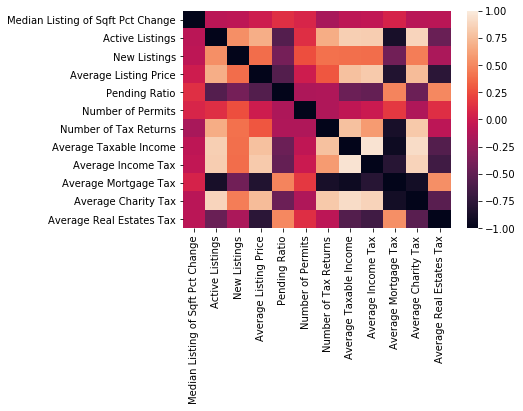

In [59]:
sns.heatmap(dict_of_corr[77026], vmin=-1, vmax=1)

In [61]:
dict_of_frames = {}
lr = LinearRegression()
dict_of_roi = {}
dict_of_strongest_corr = {}

for i in dict_of_corr.keys():
    if i in filtered_median_list_sqft_df and i in filtered_median_list_sqft_df_pct_change and i in filtered_active_listings_df and i in filtered_new_listing_df and i in filtered_average_listing_price_df and i in filtered_pending_ratio_df and i in filtered_permits_by_zip and i in filtered_number_of_returns_df and i in filtered_taxable_income_df and i in filtered_income_tax_df and i in filtered_mortgage_tax_df and i in filtered_charity_tax_df and i in filtered_real_estates_tax_df:
        dict_of_frames[i] = pd.DataFrame({
            'Median Listing of Sqft Pct Change' : filtered_median_list_sqft_df_pct_change[i], 
            'Active Listings' : filtered_active_listings_df[i], 
            'New Listings' : filtered_new_listing_df[i], 
            'Average Listing Price' : filtered_average_listing_price_df[i],
            'Pending Ratio' : filtered_pending_ratio_df[i],
            'Number of Permits' : filtered_permits_by_zip[i],
            'Number of Tax Returns' : filtered_number_of_returns_df[i],
            'Average Taxable Income' : filtered_taxable_income_df[i],
            'Average Income Tax' : filtered_income_tax_df[i],
            'Average Mortgage Tax' : filtered_mortgage_tax_df[i],
            'Average Charity Tax' : filtered_charity_tax_df[i],
            'Average Real Estates Tax' : filtered_real_estates_tax_df[i]
            })
    dict_of_frames[i].dropna(inplace=True)
    max_df = dict_of_corr[i].agg({'Median Listing of Sqft Pct Change' : ['max']})
    if max_df.values[0][0] == -2:
        print(f"Data Set Incomplete: Removing {[i]}")
        del dict_of_frames[i]
    else:
        strong_corr = dict_of_corr[i].index[dict_of_corr[i]['Median Listing of Sqft Pct Change'] == max_df.values[0][0]].tolist()
        print(f"{strong_corr[0]} {[i]}")
        dict_of_strongest_corr[i] = strong_corr[0]
        index_df = pd.DataFrame(np.array(dict_of_frames[i].index))
        lr.fit(index_df[[0]], dict_of_frames[i][[strong_corr[0]]])
        future = lr.predict([index_df.iloc[-1]+12])
        lr.fit(dict_of_frames[i][[strong_corr[0]]], dict_of_frames[i]['Median Listing of Sqft Pct Change'])
        print(f"ROI:") 
        print(lr.predict(future))
        dict_of_roi[i] = lr.predict(future)

New Listings [77048]
ROI:
[0.02093053]
Average Listing Price [77045]
ROI:
[0.03698267]
Average Listing Price [77061]
ROI:
[0.02083444]
Number of Permits [77035]
ROI:
[0.00155184]
Active Listings [77051]
ROI:
[0.00256936]
Pending Ratio [77033]
ROI:
[0.01049877]
Number of Permits [77096]
ROI:
[-0.00044714]
New Listings [77054]
ROI:
[0.00554112]
Average Listing Price [77025]
ROI:
[-0.00709937]
Pending Ratio [77087]
ROI:
[0.01548725]
Average Real Estates Tax [77017]
ROI:
[-0.02179578]
Pending Ratio [77021]
ROI:
[-0.00266863]
Pending Ratio [77030]
ROI:
[-0.02466863]
Pending Ratio [77081]
ROI:
[0.00597297]
Average Income Tax [77005]
ROI:
[0.0055603]
New Listings [77012]
ROI:
[0.01965908]
Average Listing Price [77023]
ROI:
[0.00706455]
New Listings [77004]
ROI:
[-0.00069256]
Average Mortgage Tax [77046]
ROI:
[-0.01013335]
Average Listing Price [77098]
ROI:
[0.00309937]
New Listings [77063]
ROI:
[0.00011556]
Average Charity Tax [77027]
ROI:
[0.00870845]
Number of Permits [77006]
ROI:
[0.000264

In [71]:
# Creating dictionaries and lists and dataframes to be able to do our visualization 

greatest_sorted_dict_of_roi = sorted(dict_of_roi.items(), key = operator.itemgetter(1), reverse = True)
least_sorted_dict_of_roi = sorted(dict_of_roi.items(), key = operator.itemgetter(1))

values_of_strongest_corr = []
for line in dict_of_strongest_corr:
    values_of_strongest_corr.append(dict_of_strongest_corr[line])
    
keys_of_corr = Counter(values_of_strongest_corr).keys()
count_of_corr = Counter(values_of_strongest_corr).values()

dict_of_count_of_corr_values = {}
dict_of_count_of_corr_values.update(zip(keys_of_corr, count_of_corr))

# getting the top 10 ROI's
top_dict_of_roi = {}
count = 0
for zip_code in greatest_sorted_dict_of_roi:
    top_dict_of_roi[zip_code[0]]=zip_code[1][0]
    count+=1
    if count > 9:
        break

### Visualization of our results

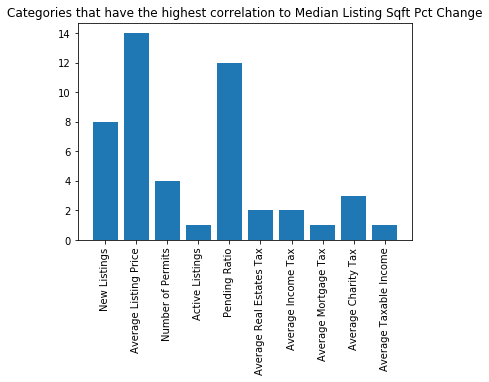

In [66]:
# Bar chart of categories that have the higest correlation to Median Listing Sqft Pct Change

plt.bar(range(len(dict_of_count_of_corr_values)), list(dict_of_count_of_corr_values.values()), align='center')
plt.xticks(range(len(dict_of_count_of_corr_values)), list(dict_of_count_of_corr_values.keys()), rotation = 90)
plt.title("Categories that have the highest correlation to Median Listing Sqft Pct Change")
plt.show()

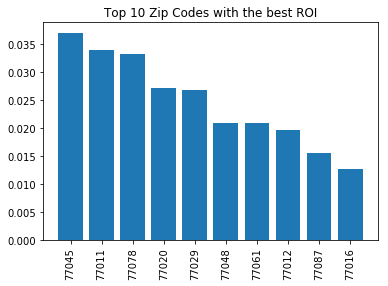

In [72]:
# Bar chart with the top ROI

plt.bar(range(len(top_dict_of_roi)), list(top_dict_of_roi.values()), align='center')
plt.xticks(range(len(top_dict_of_roi)), list(top_dict_of_roi.keys()), rotation = 90)
plt.title("Top 10 Zip Codes with the best ROI")
plt.show()

In [75]:
# Coding out the Mapbox

dict_for_heatmap = {}
count = 0
for zip_code in greatest_sorted_dict_of_roi:
    dict_for_heatmap[zip_code[0]]=(zip_code[1][0] + 1)
    
heatmap_df = pd.DataFrame(list(dict_for_heatmap.items()),columns = ['zip_code','ROI']) 
heatmap_df = heatmap_df.set_index("zip_code").transpose()
lat_long_zip_roi_df = pd.concat([zip_lat_df, zip_long_df, heatmap_df], join="inner").transpose()
lat_long_zip_roi_df.columns = ('Latitude', 'Longitude', 'ROI')
lat_long_zip_roi_df.reset_index(inplace = True)

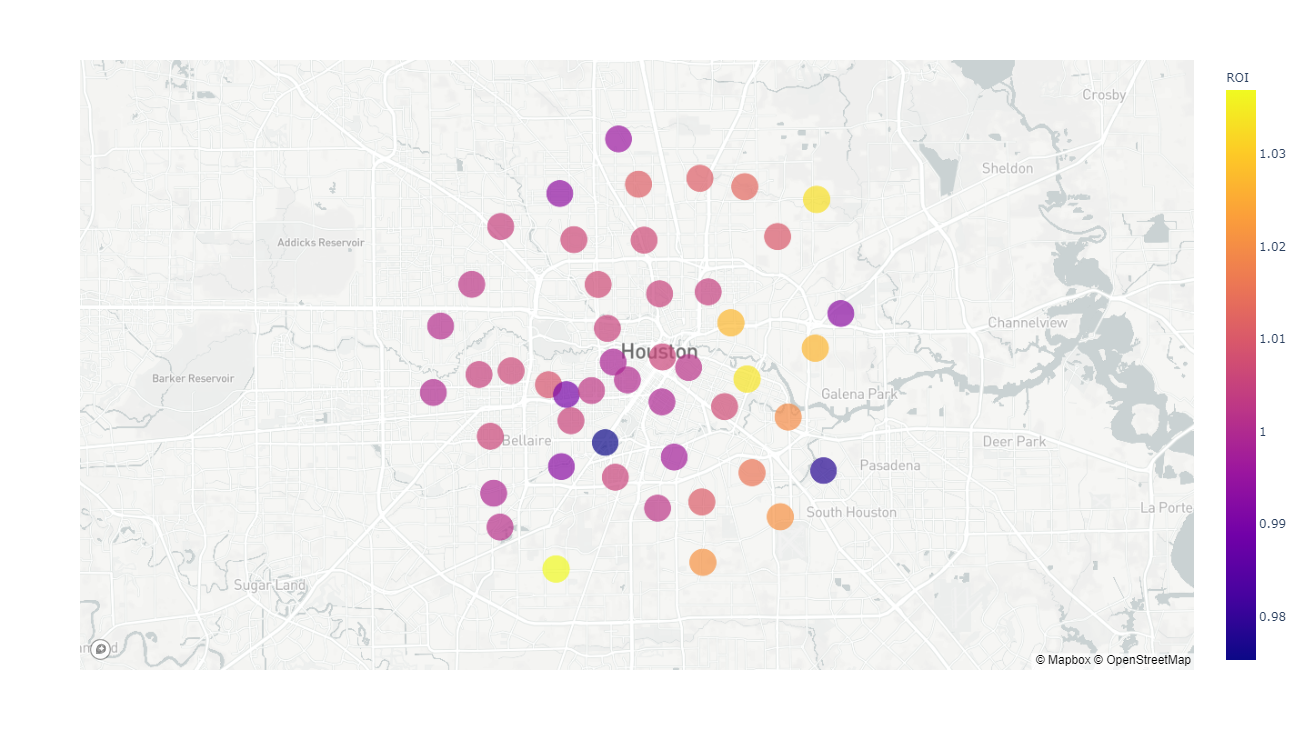

In [76]:
map = px.scatter_mapbox(
    lat_long_zip_roi_df,
    lat="Latitude",
    lon="Longitude",
    #text="Zip",
    size="ROI",
    color="ROI",
    hover_name="index",
    zoom=10,
    height = 750
)

# Display the map
map.show()